In [1]:
# find best features for multi-lable classification modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score

In [5]:
import os
os.getcwd()

'D:\\python3\\Scripts'

In [6]:
os.chdir('D:/project/gatsby')

In [16]:
data = pd.read_csv('feature_data21.csv')
X = data.drop(data.columns[[0,1]], axis=1)
y = data.id

In [12]:
clf = Pipeline(
    [
        ("anova", SelectKBest(f_classif)),
        ("scaler", StandardScaler()),
        ("svc", LinearSVC(dual="auto")),
    ]
)

score_means = list()
score_stds = list()
nfs = range(1, len(X.columns)+1)

for n in nfs:
    clf.set_params(anova__k=n)
    this_scores = cross_val_score(clf, X, y, cv = ms.StratifiedKFold(shuffle = True))
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

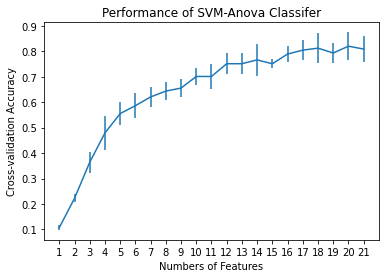

In [13]:
plt.errorbar(nfs, score_means, np.array(score_stds))
plt.title("Performance of SVM-Anova Classifer")
plt.xticks(nfs)
plt.xlabel("Numbers of Features")
plt.ylabel("Cross-validation Accuracy")
plt.axis("tight")
plt.show()

In [14]:
# calculate the precision, recall and f1-score of features
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

In [19]:
# define feature selection
fs = SelectKBest(score_func=f_classif, k=17)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)
anova_filter = fs
clf = LinearSVC(dual="auto")
anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(X, y)
y_pred = anova_svm.predict(X)
print(classification_report(y, y_pred))

(270, 17)
              precision    recall  f1-score   support

        deng       0.63      0.57      0.60        30
        lijc       0.82      0.93      0.87        30
        lijh       0.81      0.73      0.77        30
        qiao       0.82      0.77      0.79        30
          su       0.74      0.93      0.82        30
        wang       0.91      0.97      0.94        30
          wu       0.60      0.70      0.65        30
         yao       0.55      0.37      0.44        30
       zhang       0.90      0.87      0.88        30

    accuracy                           0.76       270
   macro avg       0.75      0.76      0.75       270
weighted avg       0.75      0.76      0.75       270



In [20]:
# getting Fisher's Scores for all features
def get_numerical_features(features, class_label):
    #class_label is already a Dataframe in your data demo
    fs=SelectKBest(f_classif, k='all')
    fs.fit(features, class_label)

    for i, feature in zip(range(len(features)), features): 
        print('Feature %s: %f' % (feature, fs.scores_[i]))

# applying the function
get_numerical_features(features=X, class_label=y)

Feature kttr: 20.591673
Feature hapax: 1.144448
Feature rwr: 4.679768
Feature cwr: 11.111315
Feature idm: 10.942197
Feature mwr: 11.907398
Feature nn: 4.260669
Feature vv: 4.867365
Feature jj: 2.605742
Feature ad: 14.858983
Feature con: 59.581049
Feature cc: 3.396509
Feature pp: 9.454975
Feature pn: 3.983249
Feature n2v: 2.140895
Feature v2j: 2.248868
Feature asl: 14.992267
Feature pun: 4.293977
Feature mdd: 9.465588
Feature ba: 9.327176
Feature bei: 10.672968


In [23]:
# calculate accuracy scores for all pairs
df = pd.read_csv('feature_data17.csv')
labels = ['qiao','wu','yao','wang','lijh','deng','zhang','su','lijc'][::-1]
fs = SelectKBest(score_func=f_classif, k='all')
clf = LinearSVC(dual="auto")
ascore = []
for i in range(8):
    for j in range(1, 9):
        if i>=j: continue
        data = df.loc[(df['id'] == labels[i])|(df['id'] == labels[j])]
        X = data.drop(data.columns[[0,1]], axis=1)
        y = data.id
        anova_svm = make_pipeline(fs, clf)
        anova_svm.fit(X, y)
        y_pred = anova_svm.predict(X)
        acs = accuracy_score(y, y_pred)
        pa = (labels[i], labels[j], acs)
        ascore.append(pa)
df_ascore = pd.DataFrame(ascore)
df_ascore.columns = ['V1', 'V2', 'Accuracy']
df_ascore.to_csv('pair-wise_accuracy_scores.csv', sep=',', index=False)

In [24]:
# transform the data into a table
df=df_ascore
df.V1=pd.Categorical(df.V1, categories=df.V1.unique()[::-1], ordered=True)
df.V2=pd.Categorical(df.V2, categories=df.V2.unique(), ordered=True)
tab = df.pivot_table(index='V1', columns='V2', values='Accuracy', sort=False).rename_axis(index=None, columns=None)#.T
tab = tab.iloc[::-1, ::-1]
tab.to_csv('pair-wise_accuracy_scores2.csv', sep=',', index=True)